In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

dataframe = pd.read_excel(io.BytesIO(uploaded['mydata.xlsx']))

Saving mydata.xlsx to mydata (1).xlsx


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch

# Let's assume that the second column is the target and the rest are the features
# We exclude the first column (date)
data = dataframe.iloc[:, 1:].values

# Scale your data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare your data with some function, e.g., create_dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  # All columns including the target
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # The target column
    return np.array(X), np.array(Y)

# Create the dataset
look_back = 10  # Increase the number of previous time steps
x, y = create_dataset(data, look_back)

# Determine the number of time periods to allocate as the test set (24 months for 2 years)
test_periods = 12

# Calculate the index to split the data
split_index = len(x) - test_periods

# Split the data into train and test sets
x_train, x_test = x[:split_index, :], x[split_index:, :]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

def build_model(hp):
    model = Sequential()

    # Tune the number of filters and kernel size in the Conv1D layers
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])

    model.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Flatten())

    # Tune the number of units in the Dense layer
    hp_units = hp.Int('units', min_value=30, max_value=120, step=10)
    model.add(Dense(units=hp_units, activation='relu'))

    model.add(Dense(1))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define early stopping with patience=20 (or any other value you choose)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Define Keras Tuner random search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld'
)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=2)

# Evaluate the model on the test set
test_loss = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)

Trial 5 Complete [00h 00m 16s]
val_loss: 0.005186117719858885

Best val_loss So Far: 0.0025632215353349843
Total elapsed time: 00h 00m 39s
Epoch 1/500
8/8 - 1s - loss: 0.2773 - val_loss: 0.0958 - 880ms/epoch - 110ms/step
Epoch 2/500
8/8 - 0s - loss: 0.0598 - val_loss: 0.0440 - 69ms/epoch - 9ms/step
Epoch 3/500
8/8 - 0s - loss: 0.0275 - val_loss: 0.0424 - 47ms/epoch - 6ms/step
Epoch 4/500
8/8 - 0s - loss: 0.0138 - val_loss: 0.0208 - 45ms/epoch - 6ms/step
Epoch 5/500
8/8 - 0s - loss: 0.0100 - val_loss: 0.0147 - 54ms/epoch - 7ms/step
Epoch 6/500
8/8 - 0s - loss: 0.0077 - val_loss: 0.0127 - 70ms/epoch - 9ms/step
Epoch 7/500
8/8 - 0s - loss: 0.0062 - val_loss: 0.0120 - 68ms/epoch - 9ms/step
Epoch 8/500
8/8 - 0s - loss: 0.0054 - val_loss: 0.0109 - 68ms/epoch - 8ms/step
Epoch 9/500
8/8 - 0s - loss: 0.0045 - val_loss: 0.0102 - 55ms/epoch - 7ms/step
Epoch 10/500
8/8 - 0s - loss: 0.0042 - val_loss: 0.0089 - 52ms/epoch - 7ms/step
Epoch 11/500
8/8 - 0s - loss: 0.0039 - val_loss: 0.0083 - 49ms/epoc

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 48)             1776      
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                23100     
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 24,937
Trainable params: 24,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 73ms/step
[[0.73617625]
 [0.6545953 ]
 [0.8060797 ]
 [0.9275438 ]
 [0.8825443 ]
 [0.79104096]
 [0.7110445 ]
 [0.8042407 ]
 [0.93240386]
 [0.9405497 ]
 [0.8661009 ]
 [0.8178059 ]]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# 평균 제곱근 오차(RMSE) 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# 평균 절대 오차(MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# MAPE 계산
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

RMSE: 0.06463215865188557
MAE: 0.05878068020876353
MAPE: 0.07347597359016765


In [ ]:

from sklearn.metrics import r2_score

# 결정 계수를 계산합니다.
r2 = r2_score(y_test, y_pred)

# 결정 계수를 출력합니다.
print("R^2 Score:", r2)

R^2 Score: 0.6966398365101099


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract the optimal hyperparameter values
units = best_hps.get('units')
learning_rate = best_hps.get('learning_rate')

# Print the optimal hyperparameter values
print("Optimal Hyperparameters:")
print("Units:", units)
print("Learning Rate:", learning_rate)

Optimal Hyperparameters:
Units: 60
Learning Rate: 0.001


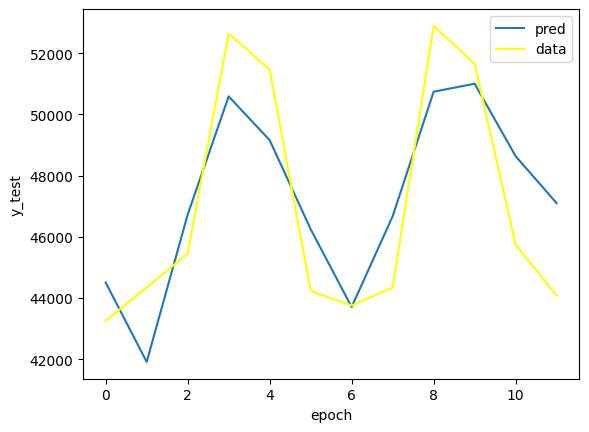

[[44502.543]
 [41909.1  ]
 [46724.758]
 [50586.082]
 [49155.555]
 [46246.68 ]
 [43703.61 ]
 [46666.297]
 [50740.582]
 [50999.54 ]
 [48632.824]
 [47097.53 ]]
[43253.54509 44340.78814 45453.43341 52643.66332 51461.29845 44230.74019
 43753.94057 44338.6556  52889.45221 51651.5616  45739.50828 44077.47262]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_or = y_pred*(52889.45221-21099.635)+21099.635
y_test_or = y_test*(52889.45221-21099.635)+21099.635
plt.plot(y_pred_or, label='pred')
plt.plot(y_test_or, label='data',color = 'yellow')
plt.ylabel('y_test')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
print(y_pred_or)
print(y_test_or)